### import packages

In [1]:
import datascience as ds
from datascience import *
import numpy as np
from graphviz import Source
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.externals import joblib
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### tweets data loaded into Jupyter Notebook as Table object

In [2]:
t1 = Table.read_table("Climate1SupportiveLevel.csv",sep=',')
t2 = Table.read_table("ClimateBalancedDS2.csv",sep=',')
T3 = t1.append(t2)
T3

Text,Support
RT @kasserolees: Energy is the #1 contributer to climate ...,1
RT @edelman_barbara: @msnbc why don t you have a climate ...,1
RT @OtagoGrad: @anthonyfurey @OskieOckham The data doesn ...,0
The Dow just recorded its 3rd worst day ever. Think @rea ...,0
RT @SimonBanksHB: I am not going to rule out things base ...,0
RT @sydneyleemarco: nothing like an 80 degree october da ...,1
@MerlenesMemos @CNN It's not an act of god. Climate chan ...,1
RT @MikeLevinCA: When asked about climate change my GOP ...,0
RT @gq_jayq: Bet I got 11 years to run it up https://t.c ...,0
No they care about the oil billionaires,0


In [3]:
T3.to_csv("MergedLabelledData.csv")

### Preprocess

In [4]:
X = list(T3['Text'])
y = list(T3['Support'])

### Check whether the data distribution is balanced

In [5]:
def check(sentiment, index, note='training'):
    if sentiment==0:
        label = 'not supportive'
    else:
        label = 'supportive'
    print('There are {} '.format(T3.take(index).where('Support', 
          are.equal_to(sentiment)).size[0][0])+label+' tweets in the '+note+' set.')

#### Model Building

In [6]:
def custom_split(train_index, test_index):
    trainingset = T3.take(train_index)
    testingset = T3.take(test_index)    
        
    X_train= list(trainingset['Text'])
    y_train= list(trainingset['Support'])
    X_test= list(testingset['Text'])
    y_test= list(testingset['Support'])
    
    return X_train, X_test, y_train, y_test

### classifier

In [65]:
def classifier(X_train, y_train, X_test, fold, max_depth, min_samples_leaf):
    # add stop_words
    clf = Pipeline(
        [
            ('vect', CountVectorizer(stop_words= ['a', 'an', 'the', 'it', 'is', 'are', 'be', 'of', 'this', 'that', 'RT', 'rt','https'],
                                     token_pattern='(([#@]|[0-9]|[a-z]|[A-Z])+)',
                                     analyzer = 'word',
                                     min_df = 2)),
            ('clf', DecisionTreeClassifier(criterion='entropy',
                                           random_state = 100,
                                           max_depth = max_depth,
                                           min_samples_leaf = min_samples_leaf))
        ])
    clf.fit(X_train, y_train)
    feature_names = clf.named_steps['vect'].get_feature_names()
    try:
        dot_data = tree.export_graphviz(clf.named_steps['clf'], out_file=None, 
                                        feature_names=feature_names)
        graph = Source(dot_data)
        graph.render('ClimateClassifier-Fold_{}'.format(fold))
    except Exception as e:
        print(e)
    predicted_y_train = clf.predict(X_train)
    predicted_y_test = clf.predict(X_test)
    # save as pickle
    joblib.dump(clf, 'ClimateTeam7PD2.pkl')
    return predicted_y_train, predicted_y_test

### evaluation

In [61]:
def eval_results(predicted_y_train, y_train, predicted_y_test, y_test):
    accuracy_s = accuracy_score(y_test, predicted_y_test)
    precision_s = precision_score(y_test, predicted_y_test)
    recall_s = recall_score(y_test, predicted_y_test)
    f1_s = f1_score(y_test, predicted_y_test)
    cm_train = confusion_matrix(y_train, predicted_y_train)
    cm_test = confusion_matrix(y_test, predicted_y_test)  
    
    print('Accuracy Score:', accuracy_s)
    print("Precision Score:", precision_s)
    print("Recall Score:", recall_s)
    print("f1 Score:", f1_s)
    print('confusion_matrix of training set is: \n', cm_train, '\n')
    print('confusion_matrix of testing set is: \n', cm_test, '\n')
    print(classification_report(y_test, predicted_y_test))
    
    classes = ['not supportive', 'supportive']
    sns.heatmap(cm_train, annot=True, cmap='Blues', yticklabels=classes, xticklabels=classes)
    plt.title('confusion matrix of training set')
    plt.show()
    sns.heatmap(cm_test, annot=True, cmap='Blues', yticklabels=classes, xticklabels=classes)
    plt.title('confusion matrix of testing set')
    plt.show()
    return accuracy_s, precision_s, recall_s, f1_s

### k-fold

In [62]:
def k_fold_evaluate(X, y, max_depth, min_samples_leaf):
    # initialization
    accuracy = []
    precision = []
    recall=[]
    f1 = []
    fold = 1
    skf = StratifiedKFold(n_splits=5, random_state=1, shuffle= True)
    
    # build model and collect results
    for train_index, test_index in skf.split(X, y):
        if fold==1:
            list(map(lambda x: check(x, train_index), range(2)))
            list(map(lambda x: check(x, test_index, note='testing'), range(2)))
        
        X_train, X_test, y_train, y_test = custom_split(train_index, test_index)
        
        predicted_y_train, predicted_y_test = classifier(X_train=X_train, y_train=y_train, 
                                                          X_test=X_test, fold=fold,
                                                          max_depth = max_depth,
                                                          min_samples_leaf = min_samples_leaf)
        
        print('\nFold: {}'.format(fold))
        accuracy_s, precision_s, recall_s, f1_s = eval_results(predicted_y_train, y_train, predicted_y_test, y_test)
        
        accuracy.append(accuracy_s)
        precision.append(precision_s)
        recall.append(recall_s)
        f1.append(f1_s)
        
        metrics_T3 = pd.DataFrame(
                    {
                        'accuracy': accuracy,
                        'precision': precision,
                        'recall':recall,
                        'f1':f1
                    }
                )
        fold += 1
    return metrics_T3

### chosen parameters: `max_depth=7, min_samples_leaf=2`

Because the 5-fold f1 score of max_depth=7, min_samples_leaf=2 are better.

c:\users\administrator\appdata\local\programs\python\python35-32\lib\site-packages\datascience\tables.py:192: FutureWarning: Implicit column method lookup is deprecated.
  warnings.warn("Implicit column method lookup is deprecated.", FutureWarning)


There are 1093 not supportive tweets in the training set.
There are 1212 supportive tweets in the training set.
There are 274 not supportive tweets in the testing set.
There are 304 supportive tweets in the testing set.
failed to execute ['dot', '-Tpdf', '-O', 'ClimateClassifier-Fold_1'], make sure the Graphviz executables are on your systems' PATH

Fold: 1
Accuracy Score: 0.6228373702422145
Precision Score: 0.6194444444444445
Recall Score: 0.7335526315789473
f1 Score: 0.6716867469879518
confusion_matrix of training set is: 
 [[594 499]
 [232 980]] 

confusion_matrix of testing set is: 
 [[137 137]
 [ 81 223]] 

             precision    recall  f1-score   support

          0       0.63      0.50      0.56       274
          1       0.62      0.73      0.67       304

avg / total       0.62      0.62      0.62       578



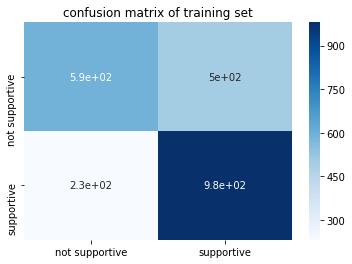

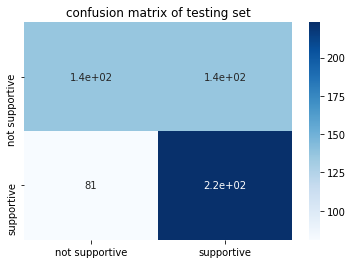

failed to execute ['dot', '-Tpdf', '-O', 'ClimateClassifier-Fold_2'], make sure the Graphviz executables are on your systems' PATH

Fold: 2
Accuracy Score: 0.6568457538994801
Precision Score: 0.6356589147286822
Recall Score: 0.8118811881188119
f1 Score: 0.7130434782608697
confusion_matrix of training set is: 
 [[599 494]
 [237 976]] 

confusion_matrix of testing set is: 
 [[133 141]
 [ 57 246]] 

             precision    recall  f1-score   support

          0       0.70      0.49      0.57       274
          1       0.64      0.81      0.71       303

avg / total       0.67      0.66      0.65       577



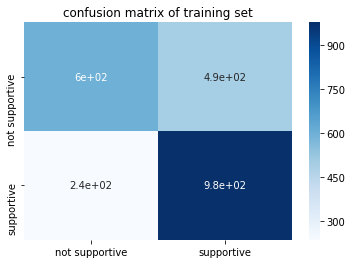

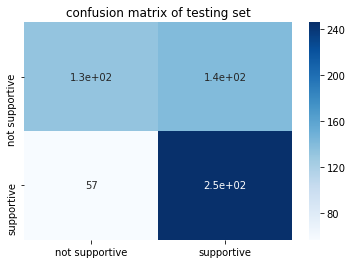

failed to execute ['dot', '-Tpdf', '-O', 'ClimateClassifier-Fold_3'], make sure the Graphviz executables are on your systems' PATH

Fold: 3
Accuracy Score: 0.640625
Precision Score: 0.6363636363636364
Recall Score: 0.7392739273927392
f1 Score: 0.683969465648855
confusion_matrix of training set is: 
 [[606 488]
 [260 953]] 

confusion_matrix of testing set is: 
 [[145 128]
 [ 79 224]] 

             precision    recall  f1-score   support

          0       0.65      0.53      0.58       273
          1       0.64      0.74      0.68       303

avg / total       0.64      0.64      0.64       576



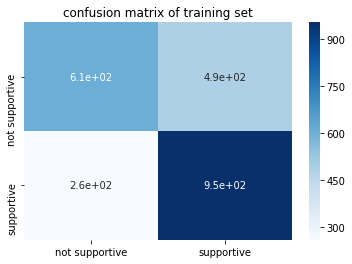

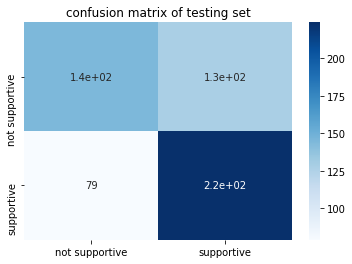

failed to execute ['dot', '-Tpdf', '-O', 'ClimateClassifier-Fold_4'], make sure the Graphviz executables are on your systems' PATH

Fold: 4
Accuracy Score: 0.6128472222222222
Precision Score: 0.6111111111111112
Recall Score: 0.7260726072607261
f1 Score: 0.6636500754147814
confusion_matrix of training set is: 
 [[610 484]
 [250 963]] 

confusion_matrix of testing set is: 
 [[133 140]
 [ 83 220]] 

             precision    recall  f1-score   support

          0       0.62      0.49      0.54       273
          1       0.61      0.73      0.66       303

avg / total       0.61      0.61      0.61       576



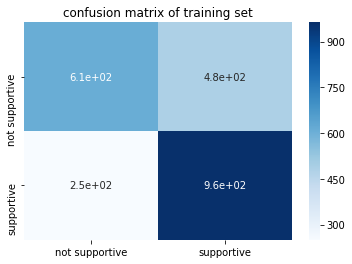

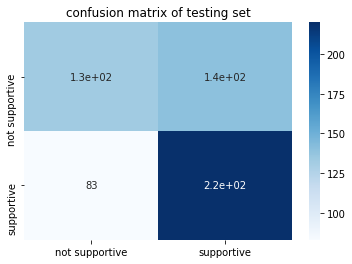

failed to execute ['dot', '-Tpdf', '-O', 'ClimateClassifier-Fold_5'], make sure the Graphviz executables are on your systems' PATH

Fold: 5
Accuracy Score: 0.6111111111111112
Precision Score: 0.6100278551532033
Recall Score: 0.7227722772277227
f1 Score: 0.6616314199395771
confusion_matrix of training set is: 
 [[622 472]
 [245 968]] 

confusion_matrix of testing set is: 
 [[133 140]
 [ 84 219]] 

             precision    recall  f1-score   support

          0       0.61      0.49      0.54       273
          1       0.61      0.72      0.66       303

avg / total       0.61      0.61      0.61       576



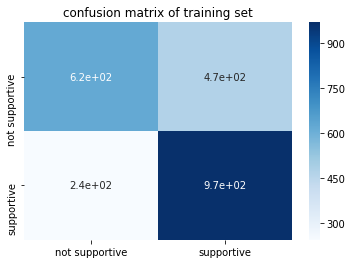

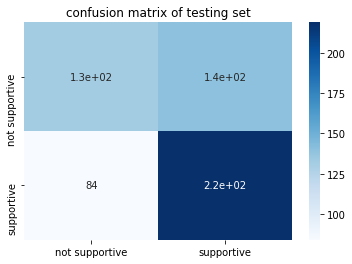

,accuracy,f1,precision,recall
0,0.622837,0.671687,0.619444,0.733553
1,0.656846,0.713043,0.635659,0.811881
2,0.640625,0.683969,0.636364,0.739274
3,0.612847,0.663650,0.611111,0.726073
4,0.611111,0.661631,0.610028,0.722772


In [66]:
k_fold_evaluate(X, y, max_depth=7, min_samples_leaf=2)

### reload pickle

In [73]:
clf2 = joblib.load('ClimateTeam7PD2.pkl')
y_pred = clf2.predict(X)
f1_score(y, y_pred)

0.7161387631975866

compare with the model generated for PD1

In [71]:
clf3 = joblib.load('ClimateTeam7PD1.pkl')
y_pred = clf3.predict(X)
f1_score(y, y_pred)

0.7017543859649124